# HDIM2 calibration

First create artificial returns from simple surrogate order-flow and the HDIM2 model. Then try to recover the kernels again and to predict the return using several different models. You might need to `pip install matplotlib colorednoise` if you didn't install all of these optional packages yet.

In [1]:
# import external dependencies
# ----------------------------

# set the backend
import matplotlib
matplotlib.use('nbagg') # set plotting backend
import matplotlib.pyplot as plt
plt.ion()

# standard packages
import numpy as np
import pandas as pd

# included noise generator
from colorednoise import powerlaw_psd_gaussian
# propagator models
import priceprop as prop
import scorr as spec

### Generate power-law correlated order-flow
Cross-correlations e.g. from returns to later signs are neglected. The purpose here is to demonstrate the model calibration and not to generate the most realistic order-flows possible.

In [2]:
# autocorrelation exponents
gamma_s = 0.5   # ... of the signs
gamma_c = 0.25  # ... of the price-change indicator
# time steps to simulate
steps = 10**5

In [3]:
# signs
s = np.sign(powerlaw_psd_gaussian(1-gamma_s, steps)).astype(int)
# change indicator
c = (powerlaw_psd_gaussian(1-gamma_c, steps) > 0)

### Simulate HDIM2 model with  generic power-law kernels

In [4]:
# maximum lag for propagator kernel
maxlag = 2**8
lags = np.arange(1,maxlag+1)

# time steps
t = np.arange(steps, dtype=int)

# power law kernels
kn = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s))
kc = prop.k_pow(maxlag+1, prop.beta_from_gamma(gamma_s))

kn[0] = 0
kn[1] = .2
r = prop.hdim2(s, c, kn, kc)

### Calibrate
Recover the kernels from the order flow & simulated returns

In [5]:
# shorthand
sc = s * c
sn = s * (~c)

In [6]:
# differential responses
Sc = prop.response(r, sc, maxlag=maxlag, ret='s')
Sn = prop.response(r, sn, maxlag=maxlag, ret='s')

In [7]:
%%time
# three-point correlation matrices
cvars = {
    'norm':          'cov',      # normalise to cross-covariance
    'subtract_mean': False,      # don't subtract means
    'nfft':          3 * maxlag, # fft segment length,
    'pad':           1 * maxlag
}
Cccc = spec.x3corr(c, sc, sc, **cvars)
Cnnc = spec.x3corr(c, sn, sn, **cvars)
Ccnc = spec.x3corr(c, sc, sn, **cvars)

CPU times: user 16.2 s, sys: 5.01 s, total: 21.2 s
Wall time: 21.2 s


In [8]:
kn_est, kc_est = prop.calibrate_hdim2(Cnnc, Cccc, Ccnc, Sn, Sc, maxlag=maxlag)

### Plot true and estimated model kernels 

<IPython.core.display.Javascript object>


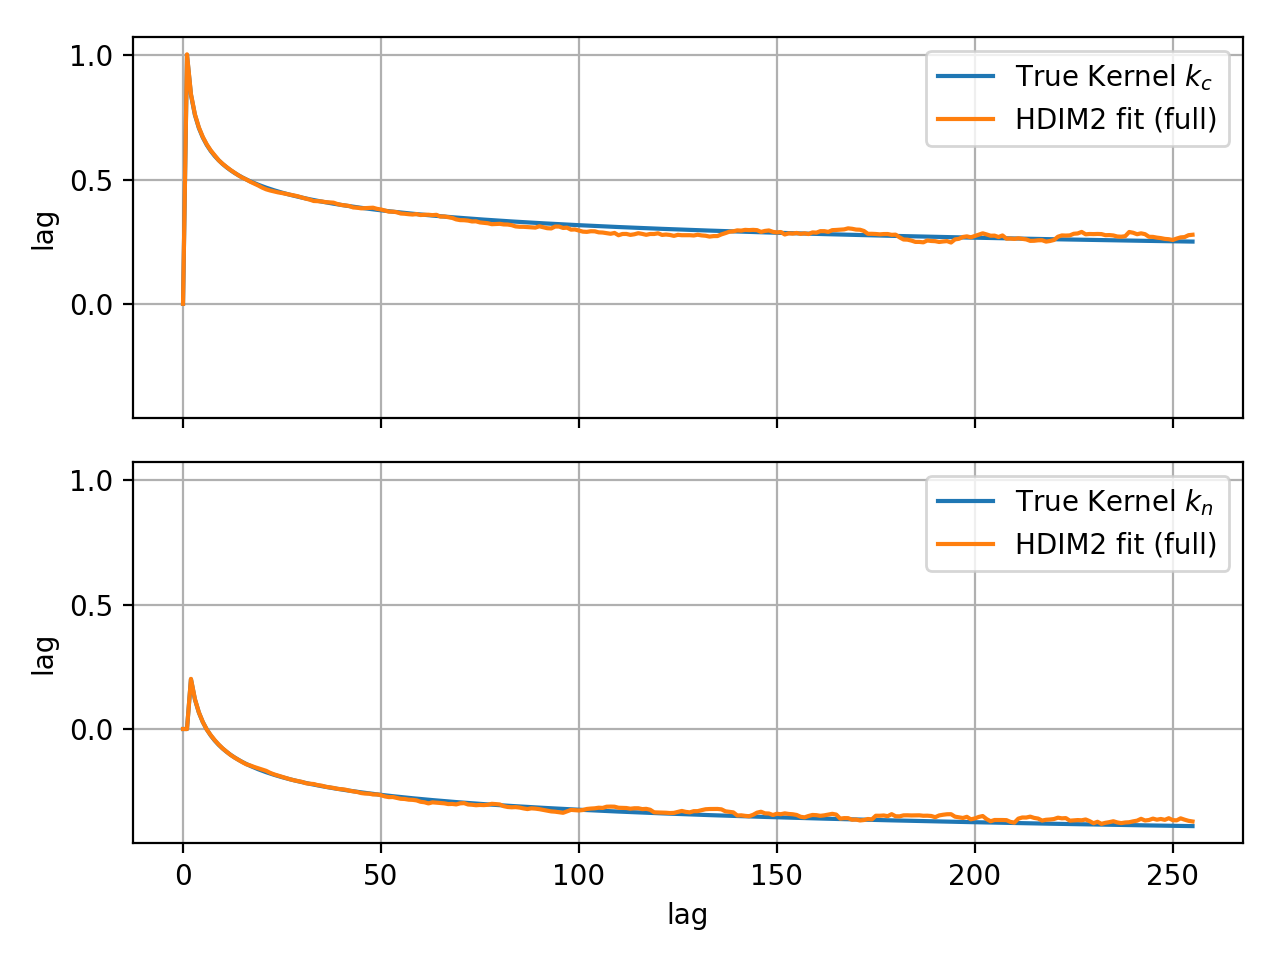

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

fn = prop.integrate # show integrated kernels

ax[0].plot(fn(kc), label='True Kernel $k_c$')
ax[0].plot(fn(kc_est), label='HDIM2 fit (full)')
ax[0].legend()

ax[1].plot(fn(kn), label='True Kernel $k_n$')
ax[1].plot(fn(kn_est), label='HDIM2 fit (full)')
ax[1].legend()

# optimise
ax[-1].set_xlabel('lag')
for a in ax.flatten():
    a.set_ylabel('lag')
    a.grid(True)

plt.tight_layout()